In [ ]:
from pydaqmx_helper.adc import ADC
from pydaqmx_helper.dac import DAC

In [1]:
from tqdm import tqdm
from glob import glob
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm

plt.rcParams.update({'font.size': 14})

In [ ]:
thermocoupleADC = ADC()
thermocoupleDAC = DAC(0)

In [ ]:
thermocoupleADC.addChannels([0, 1, 2, 3, 4, 5, 6, 7], ADC_mode="DAQmx_Val_RSE")
thermocoupleADC.getActiveChannels()

In [ ]:
thermocoupleADC.sampleVoltages()

# Calibration

In [ ]:
# Need to convert from adc pin voltage to temperature

In [2]:
def SwitchPinLayer(dac, layer):
    
    # We have 16 thermocouples but only 8 ADC ouptuts, a 16 to 8 channel switch is used
    # We describe the two sets of thermocouples as layers, and switch between them using this function
    # This function sets voltage switch to the value corresponding to the 'layer' parameter which is 0 or 1
    
    if layer == 0:
        dac.writeVoltage(0)
        
    elif layer == 1:
        dac.writeVoltage(5)
        
    else:
        raise ValueError("Parameter: 'Layer' must be of type int and either 0 or 1")
        
    return

In [3]:
def MeasureTemperatures(adc, dac, calibrationFunction=None):
    # Function to record the temperatures of all the pins
    # Returns a list with the length of the number of pins, with each value being the voltage of pin 'i'.
    
    # Define a new list containing thermocouple outputs
    
    temperatures = list()
    
    # First ensure pin switch is on layer 0
    SwitchPinLayer(dac, 0)
    
    # Record voltages for each pin
    firstPins = adc.sampleVoltages()
    
    for el in firstPins.values():
        temperatures.append(el[0]) # first element of el is needed as the values of the returned dictionary are tuples
    
    # Switch pins to second layer
    SwitchPinLayer(dac, 1)
    
    # Record voltages for each pin
    secondPins = adc.sampleVoltages()
    
    for el in secondPins.values():
        
        temperatures.append(el[0])
        
    return temperatures

In [ ]:
MeasureTemperatures(thermocoupleADC, thermocoupleDAC)

In [6]:
def SaveCalibrationData(path, temperature):
    data = MeasureTemperatures(thermocoupleADC, thermocoupleDAC)
    
    fullPath = path + "/nc_calibration_" + str(temperature)

    np.savetxt(fullPath, data)

In [ ]:
SaveCalibrationData(r"C:\Users\Student\Desktop\20302561\Calibration", "test")

In [ ]:
SaveCalibrationData(r"C:\Users\Student\Desktop\20302561\Calibration", 71.5)

## Loading Calibration Data

In [7]:
def GetCalibrationData(path):
    paths = glob(path)
    paths.sort(key = lambda x: float(x.split('_')[-1]))
    
    data = [0] * len(paths)
    temperature = [float(el.split('_')[-1]) for el in paths]
    
    for i, path in enumerate(paths):
        data[i] = np.loadtxt(path)

    return [temperature, np.array(data)]

In [8]:
def QuadraticFit(x, a, b, c):

    if type(x) == np.dtype('float64'):
        x = [x]

    output = []

    for el in x:
        output.append(a*el**2 + b*el + c)

    return output

In [9]:
def PlotCalibration(calibrationData):

    fig, ax = plt.subplots()
    
    pins = [ calibrationData[1][:,i] for i in range(len(calibrationData[1]))]

    fitPars = []
    fitCov = []

    for i, pinValues in enumerate(pins):
        
        ax.errorbar(calibrationData[0], pinValues, xerr=0.5, fmt=".", color=plt.get_cmap("viridis").__call__(i / 16), label=f"Thermocouple Index {i}")

        #print(calibrationData[0])
        #print(pinValues)

        pars, cov = curve_fit(QuadraticFit, calibrationData[0], pinValues)

        ax.plot(calibrationData[0], QuadraticFit(calibrationData[0], pars[0], pars[1], pars[2]), alpha=0.5,
                                                 color=plt.get_cmap("viridis").__call__(i / 16))

        fitPars.append(pars)
        fitCov.append(cov)

    
    ax.set_xlabel(r"Temperature ($^\circ$C)")
    ax.set_ylabel("Thermocouple Voltage (V)")
    ax.margins(0)
    ax.set_xlim(0, 90)
    #plt.legend()

    return (fitPars, fitCov)

In [10]:
def CreateCalibrationFunction(fitPars):

    def CalibrationFunction(voltages):

        temperatures = []

        for i, pinVoltage in enumerate(voltages):

            quadratic = np.polynomial.Polynomial(np.flip(fitPars[i]))

            roots = (quadratic - pinVoltage).roots()
            
            for r in roots:
                if r > 0:
                    root = r

            temperatures.append(root)

        return temperatures

    return CalibrationFunction

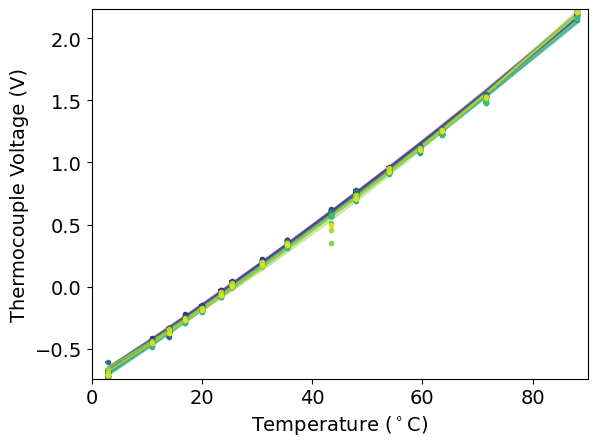

In [12]:
calibrationData = GetCalibrationData(r"../data/calibration/*")
fitPars, fitCov = PlotCalibration(calibrationData) # Thermocouple error is neglegible
CalibrationFunction = CreateCalibrationFunction(fitPars)
#print(fitPars)
#print(np.sqrt(np.diag(fitCov)))
#plt.ylim(0, 1)
#plt.xlim(30, 50)

# Experiment

In [13]:
def ExperimentRun(measurements, timeBetween):

    # measurements: Number of measurements to be made
    # timeBetween: Time to wait between each measurment (seconds)

    # files containing the data for each measurment will be saved before the next one begins

    startTime = time.time()

    for i in tqdm(range(measurements)):

        print(f"Taking measurment {i} of {measurements}")

        ## DO MEASUREMENT

        print("Measurment complete, writing to file")

        currentTime = time.time() - startTime
        currentTimeRounded = int(currentTime)

        ## Write to file. Note that filename should contain the time at which the measurment was taken

        print(f"Waiting {timeBetween} seconds")
        
        time.sleep(timeBetween)

    print("All measurments complete, exiting function")
    totalTime = time.time() - startTime
    print(f"Total time ellapsed: {totalTime}")

    return

## Plotting

In [14]:
def GetData(path):
    paths = glob(path)
    paths.sort(key = lambda x: float(x.split('_')[-1]))
    
    data = [0] * len(paths)
    time = [float(el.split('_')[-1]) for el in paths]

    for i, path in enumerate(paths):
        data[i] = np.loadtxt(path)
    
    return [time, np.array(data)]

In [15]:
def PinNumberToDistance(pinNumbers):
    # Takes pin index and return the distance from the resevoir in cm

    firstDistance = 10 # 10 cm
    interDistance = 4.6 # 46 mm

    pinDistances = []

    for pinNumber in pinNumbers:
        pinDistances.append(firstDistance + interDistance * pinNumber)

    return pinDistances

In [16]:
def dS_internal(pinTemperatures, length, furnaceTemperature):

    total = 0
    temperatures = [furnaceTemperature, *pinTemperatures]
    temperatures = [t + 273.15 for t in temperatures]

    for i in range(0, len(temperatures) - 2):
        currentT = temperatures[i]
        nextT = temperatures[i + 1]

        total += (nextT - currentT) * ((1 / nextT) - (1 / currentT))

    return ( - 1 / length) * total

def dS_external(pinTemperatures, length, beta, furnaceTemperature, t):
    
    temperatures = [furnaceTemperature, *pinTemperatures]
    temperatures = [t + 273.15 for t in temperatures]

    a = (- 1 / length) * (1 / temperatures[0]) * (temperatures[1] - temperatures[0])
    b = (1 / length) * (1 / temperatures[-1]) * (temperatures[-1] - temperatures[-2])

    c = 0

    for i in range(1, len(temperatures) - 2):

        c += -1 * (beta*100)**2 * length * (1 - (temperatures[-1] / temperatures[i]))

    if t == 5:
        print(temperatures)
        print(f"A: {a}")
        print(f"B: {b}")
        print(f"C: {c}")

    return a + b + c

In [17]:
def DetermineSteadyStateCutoff(temperatureArray, tolerance):
    # Finds the time along the array where the temperatures change by no greater than the tolerance for each pin
    timeIndex = 20

    while timeIndex < len(temperatureArray):   

        if timeIndex == len(temperatureArray) -1:
            raise Exception("Steady state not found, tolerance too high!")

        elif np.any( (temperatureArray[timeIndex + 1 ] - temperatureArray[timeIndex]) > tolerance ):
            timeIndex += 1
            continue
        
        else:
            print("Complete at t=" + str(timeIndex))
            break

    return timeIndex

def PlotSteadyState(ax, temperatureArray, plot=True):
    
    startIndex = DetermineSteadyStateCutoff(temperatureArray, 0.5)

    steadyStates = temperatureArray[startIndex:-1]

    meanTemperatures = []
    temperatureStds = []
    
    i = 0
    while i < len(steadyStates[0]):
        meanTemperatures.append(np.mean(steadyStates[:,i]))
        temperatureStds.append(np.std(steadyStates[:,i]))
        i += 1

    pinPositions = PinNumberToDistance(np.arange(len(temperatureArray.T)))
    
    # FITTING
    def ExpFunc(x, a, b):
        if type(x) == np.dtype('float64'):
            x = [x]

        output = []

        for el in x:
            output.append(a * np.exp(- b * el))

        return output

    # Subtact room temperature from mean temperatures
    roomTemperature = meanTemperatures[-1]
    meanTemperatures = meanTemperatures - roomTemperature

    pars, cov = curve_fit(ExpFunc, pinPositions, meanTemperatures, [80, 0.5], sigma=temperatureStds, absolute_sigma=True)


    # PLOTTING
    if plot:
        cmap = cm.get_cmap('inferno')

        a, b= pars
        print(pars)
        xRange = np.linspace(1, 100, 1000)
        ax.plot(xRange, ExpFunc(xRange, a, b), color=cmap(0.9), label="Exponential Fit ($Ae^{-bx}$)")

        ax.errorbar(pinPositions, meanTemperatures, yerr=temperatureStds, fmt=".", color=cmap(0.5), linewidth=1, capsize=3, label="Steady State Data")
        ax.set_ylabel(r"Temperature - T$_{room}$ ($\circ$ C)") # No need for this one with the colorbar in the middle
        ax.set_xlabel("Pin Distance (cm)")
        ax.legend()

    return (startIndex, pars, cov, roomTemperature)

In [23]:
def MakePlots(data, entropy=False, heatMap=False):

    # REFORMATING DATA
    temperatureArray = np.zeros((len(data[0]), len(data[1][0])))
    
    for i, timeRow in enumerate(temperatureArray):
        temperatures = CalibrationFunction(data[1][i]) # convert from volatages to Celcius
        temperatureArray[i] = temperatures

    # HEATMAP PLOTTING
    if heatMap:
        fig, axes = plt.subplots(1, 2, figsize=(12,6))

        x = np.arange(len(temperatureArray))
        y = PinNumberToDistance(np.arange(len(temperatureArray.T)))

        cbar = axes[0].pcolormesh(x, y, temperatureArray.T, cmap="inferno")
        fig.colorbar(cbar, label=r"Temperature ($\circ$ C)")

        axes[0].set_xlabel("Time (minutes)")
        axes[0].set_ylabel("Pin Distance (cm)") # Note we need to convert from pin number to distance from hot resevoir
        # First pin is 10 cm away from hot resevoir
        # Each pin after is 46 mm away from the previous

        startIndex, _, _, _ = PlotSteadyState(axes[1], temperatureArray)

        cutOffColour = "white"
        axes[0].axvline(startIndex, color=cutOffColour)
        axes[0].text(startIndex - 1, 70, "Steady State Cutoff\nTolerance: 0.5$^\circ \,C$", color=cutOffColour, horizontalalignment="right")

        axes[0].set_title("( c )")
        axes[1].set_title("( d )")

        plt.tight_layout()

    # ENTROPY PLOTS
    if entropy:
        fig = plt.figure()
        ax = fig.add_subplot(111)

        _, pars, cov, roomTemperature = PlotSteadyState(None, temperatureArray, plot=False)
        beta = pars[1]
        print(f"Beta: ({beta*100} +/- {np.sqrt(cov[1][1]) * 100}) 1/m")

        internalEntropy = []
        externalEntropy = []

        for i, timeRow in enumerate(temperatureArray):
            temperatures = CalibrationFunction(data[1][i]) # convert from volatages to Celcius
            temperatureArray[i] = temperatures

            length = 0.046 # 46 mm

            if i == 5:
                print(f"Furnace Temperature: ({pars[0] + roomTemperature} +/- {np.sqrt(cov[0][0])}) C")
                print(temperatures)

            internalEntropy.append(-1 *dS_internal(temperatures, length=length, furnaceTemperature=pars[0] + roomTemperature))
            externalEntropy.append(dS_external(temperatures, length, beta, pars[0] + roomTemperature, i))

        cmap = cm.get_cmap('inferno')
        print(f"EXT: {np.mean(externalEntropy[-5:-1])} +/- {np.std(externalEntropy[-5:-1])}")
        print(f"INT: {np.mean(internalEntropy[-5:-1])} +/- {np.std(internalEntropy[-5:-1])}")
        ax.scatter(np.arange(len(temperatureArray)), internalEntropy, marker=".", label=r"$\frac{-dS_i}{dt}$", color=cmap(0.5))
        ax.scatter(np.arange(len(temperatureArray)), externalEntropy, marker=".", label=r"$\frac{dS_e}{dt}$", color=cmap(0.9))

        ax.set_xlabel("Time (minutes)")
        ax.set_ylabel(r"$\frac{dS}{dt}$ (arb.)")

        ax.legend()

<>:29: SyntaxWarning: invalid escape sequence '\c'
<>:29: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_1180800/2341118038.py:29: SyntaxWarning: invalid escape sequence '\c'
  axes[0].text(startIndex - 1, 70, "Steady State Cutoff\nTolerance: 0.5$^\circ \,C$", color=cutOffColour, horizontalalignment="right")


Complete at t=40
[1.31475136e+02 5.16590782e-02]


/tmp/ipykernel_1180800/1556911531.py:45: RuntimeWarning: overflow encountered in exp
  output.append(a * np.exp(- b * el))
/tmp/ipykernel_1180800/1556911531.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno')


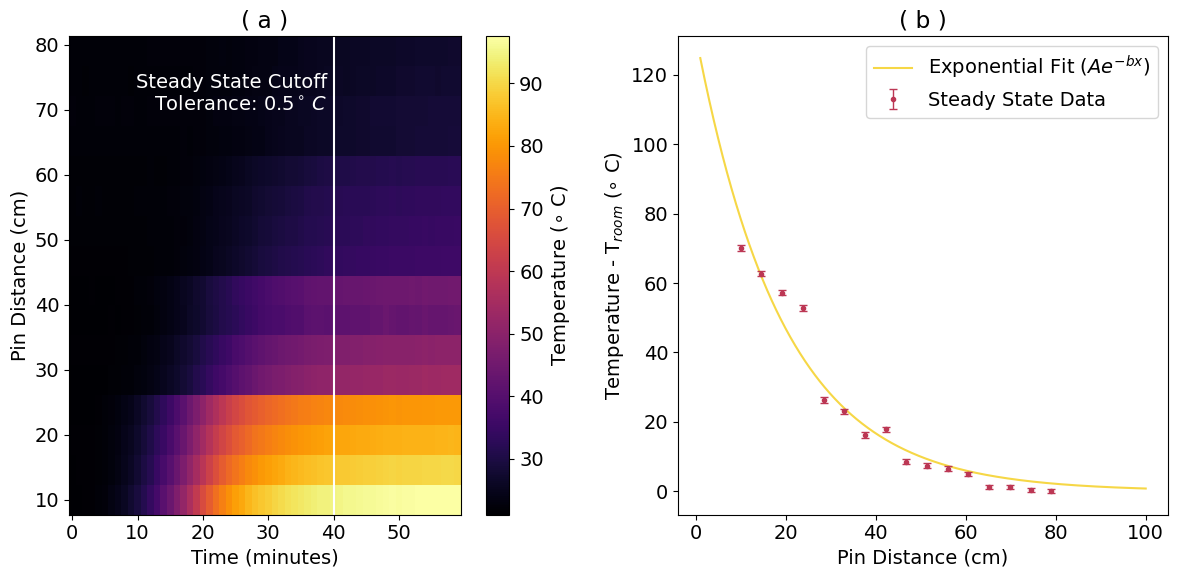

In [21]:
MakePlots(GetData("/home/daraghhollman/Main/ucd_4thYearLabs/NewtonsCooling/data/Uniform/*"), heatMap=True, entropy=False)

Complete at t=40
Beta: (5.165907822168314 +/- 0.060112855360566875) 1/m
Furnace Temperature: (157.89919748866188 +/- 1.648150788615526) C
[22.52098009479071, 22.06285973366716, 22.11755452796978, 21.99213999574022, 21.354390818915398, 21.608617697100062, 21.174761499889712, 21.307595955317147, 21.39712656572045, 21.804156061492282, 21.82499795191574, 21.687824962187555, 22.061473653663892, 22.49886003875767, 22.06476766989573, 22.00207236127147]
[431.0491974886619, 295.6709800947907, 295.21285973366713, 295.26755452796976, 295.1421399957402, 294.5043908189154, 294.7586176971, 294.3247614998897, 294.4575959553171, 294.5471265657204, 294.95415606149226, 294.9749979519157, 294.83782496218754, 295.21147365366386, 295.6488600387577, 295.2147676698957, 295.15207236127145]
A: 6.827537884538418
B: -0.004617760197066815
C: 0.010918695108608083
EXT: 1.7656794510388836 +/- 0.016215066639972787
INT: -0.6865977784818382 +/- 0.0035992490745622545


/tmp/ipykernel_1180800/1556911531.py:45: RuntimeWarning: overflow encountered in exp
  output.append(a * np.exp(- b * el))
/tmp/ipykernel_1180800/2982705687.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno')


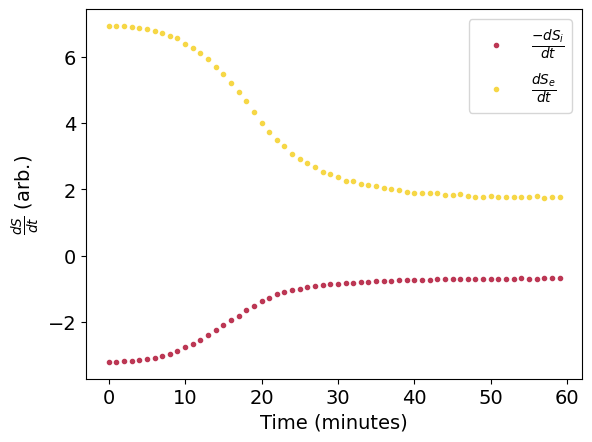

In [22]:
MakePlots(GetData("/home/daraghhollman/Main/ucd_4thYearLabs/NewtonsCooling/data/Uniform/*"), heatMap=False, entropy=True)

Complete at t=30
[1.23659838e+02 5.78949973e-02]


/tmp/ipykernel_1180800/1556911531.py:45: RuntimeWarning: overflow encountered in exp
  output.append(a * np.exp(- b * el))
/tmp/ipykernel_1180800/1556911531.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno')


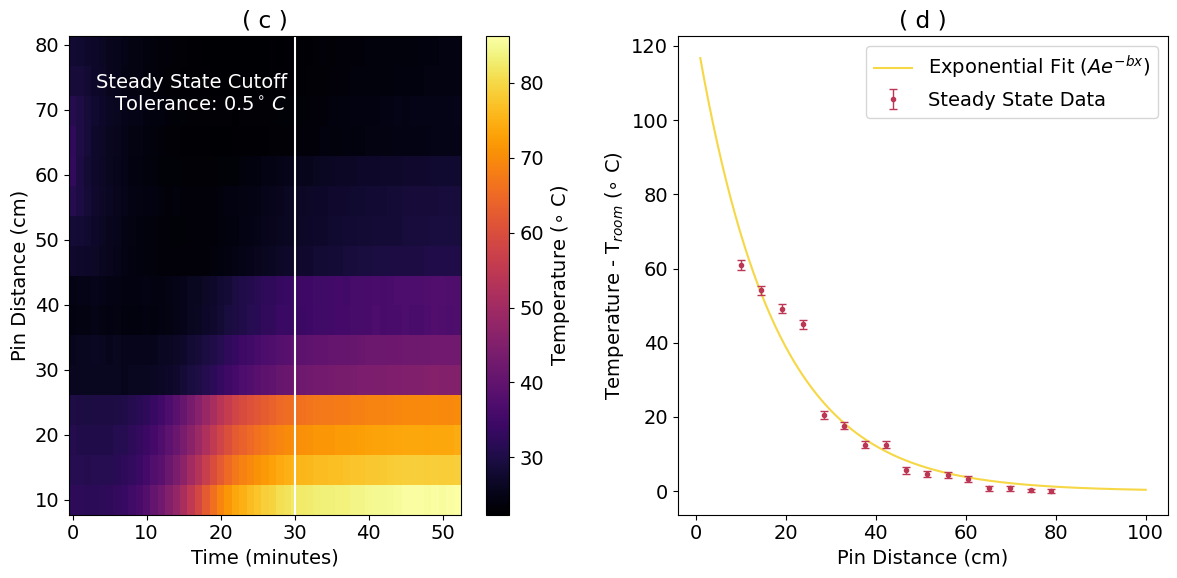

In [24]:
MakePlots(GetData("/home/daraghhollman/Main/ucd_4thYearLabs/NewtonsCooling/data/NonUniform/*"), heatMap=True, entropy=False)

Complete at t=30
Beta: (5.789499725997166 +/- 0.10534723968606945) 1/m
Furnace Temperature: (147.16596707831744 +/- 2.6984035778922615) C
[32.45982740811246, 31.14523893335278, 30.569625167500273, 29.69599880323655, 25.887608513986137, 25.508448039951798, 24.187015205545933, 24.621437841687484, 25.63037788657392, 25.678425742494113, 26.098344372393594, 25.892920362215772, 26.007213005694705, 26.31266507003041, 25.74613428699488, 25.661893036318727]
[420.3159670783174, 305.60982740811244, 304.2952389333528, 303.7196251675002, 302.8459988032365, 299.03760851398613, 298.6584480399518, 297.3370152055459, 297.7714378416875, 298.7803778865739, 298.8284257424941, 299.24834437239355, 299.04292036221574, 299.1572130056947, 299.46266507003037, 298.8961342869949, 298.8118930363187]
A: 5.932707599224616
B: -0.006128710332880056
C: -0.10336200579604853
EXT: 1.8000898840512896 +/- 0.026124723842881455
INT: -0.7002391646568079 +/- 0.002617424191552274


/tmp/ipykernel_1180800/1556911531.py:45: RuntimeWarning: overflow encountered in exp
  output.append(a * np.exp(- b * el))
/tmp/ipykernel_1180800/2341118038.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno')


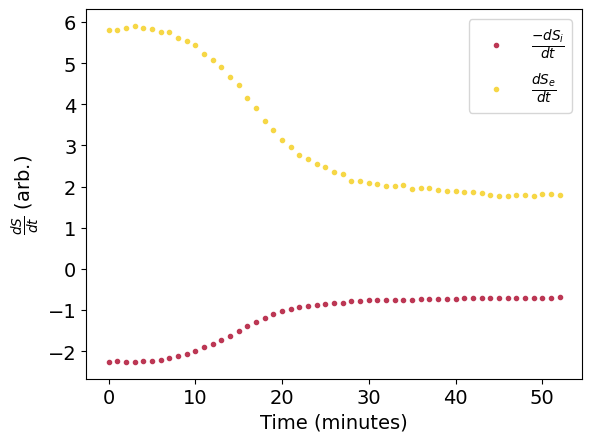

In [25]:
MakePlots(GetData("/home/daraghhollman/Main/ucd_4thYearLabs/NewtonsCooling/data/NonUniform/*"), heatMap=False, entropy=True)